# AnyoneAI - Sprint Project 04
> Vehicle Classification

You've been learning a lot about Deep Learning Algorithms, now we you're gonna be asked to put it all together. 


In [50]:
import sys

IN_COLAB = "google.colab" in sys.modules
IN_COLAB

False

In [51]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

In [52]:
if IN_COLAB:
    # Put here the full path to the folder having your Sprint project code
    # e.g. "/content/drive/MyDrive/assignment"
    ROOT_DIR = "/content/drive/MyDrive/assignment"
    %cd $ROOT_DIR

## Install dependencies (Only for Colab)

In [53]:
#if IN_COLAB:
    # This will make sure you have installed all the proper dependencies
    # Instal dependencies
    #!pip install -r requirements.txt
    # We can access to GPUs in Colab, so install GPU version of tensorflow
    #!pip install tensorflow-gpu==2.8.0

## 1. Introduction

This is a Multi-class Classification task: we want to predict, given a picture of a vehicle, which of the possible 25 classes is the correct vehicle make-model.

The dataset is composed of JPG images, already stored in folders containing the label (vehicle make-model), separated in train and test sets.


In [54]:
import os

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from src import data_utils, models, config

### Getting the data

To access the data for this project, you only need to execute the code below. This will download a zip file `cars_25_dataset.zip` containing inside:

- `car_ims_dataset`: Folder whit train and test images, already classified in sub-folders with the corresponding vehicle label.

- `train_dataset_annos.csv` and `test_dataset_annos.csv`: Train and test images annotations provided in CSV file format. You will not need these files unless you want to solve the optional exercises.


1.1. Download the training and test datasets.

In [55]:
if IN_COLAB:
    config.DATASET_ROOT_PATH = "/content/dataset/"

data_utils.download_datasets(config.DATASET_ROOT_PATH)

1.2. Setup some variables you will use during training the model.

The default values used here should work fine for you.

In [56]:
# Dataset folder
DATASET_FOLDER = os.path.join(config.DATASET_ROOT_PATH, config.DATASET_FILENAME)
DATASET_FOLDER = os.path.join(config.DATASET_ROOT_PATH, "eu-car-dataset_subset")

img_height = 224
img_width = 224
batch_size = 256

1.3. Load the training and testing images as a Tensorflow dataset (`tf.data.Dataset`).

Note that it's not a good idea to load all the images into memory because they may need more RAM than the one installed in the system. This is why we create generators using the `image_dataset_from_directory()` function, which loads the images only when they are needed and then releases the memory for loading another batch of new images from the disk.


**Don't change anything in this cell, just make it run correctly**

In [57]:
# Load train and test datasets
train_ds = keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(DATASET_FOLDER, "train"),
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(DATASET_FOLDER, "test"),
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 7509 files belonging to 25 classes.
Found 1875 files belonging to 25 classes.


**Checkpoint:** The cell above should output the following message:

```code
Found 7509 files belonging to 25 classes.
Found 1875 files belonging to 25 classes.
```

## 2. Basic EDA

Let's load and display some pictures with their labels.


2.1. Take the class names automatically inferred from the data generator and assign to `class_names` variable. We will use this to do some EDA and also to define the output units in the classification layer of our model.


**Don't change anything in this cell, just make it run correctly**

In [58]:
class_names = train_ds.class_names
print(class_names)

assert len(class_names) == 25

['abarth_595-turismo', 'abarth_grande-punto', 'bmw_z4', 'citroen_c-crosser', 'citroen_ds4', 'citroen_nemo', 'dacia_lodgy', 'ford_f-150', 'hyundai_h-350', 'hyundai_i30', 'land-rover_range-rover-velar', 'mercedes-benz_180', 'mercedes-benz_a-180', 'mercedes-benz_b-220', 'mercedes-benz_cla-220', 'mercedes-benz_cls-320', 'mercedes-benz_slk-350', 'mini_cooper-sd', 'nissan_nv400', 'nissan_primastar', 'peugeot_108', 'porsche_991', 'suzuki_ignis', 'volkswagen_fox', 'volkswagen_up!']


2.2. Let's show some pictures!

You can re-run the following cell as many times as you want and it will always show a new set of images and labels.

**Don't change anything in this cell, just make it run correctly**

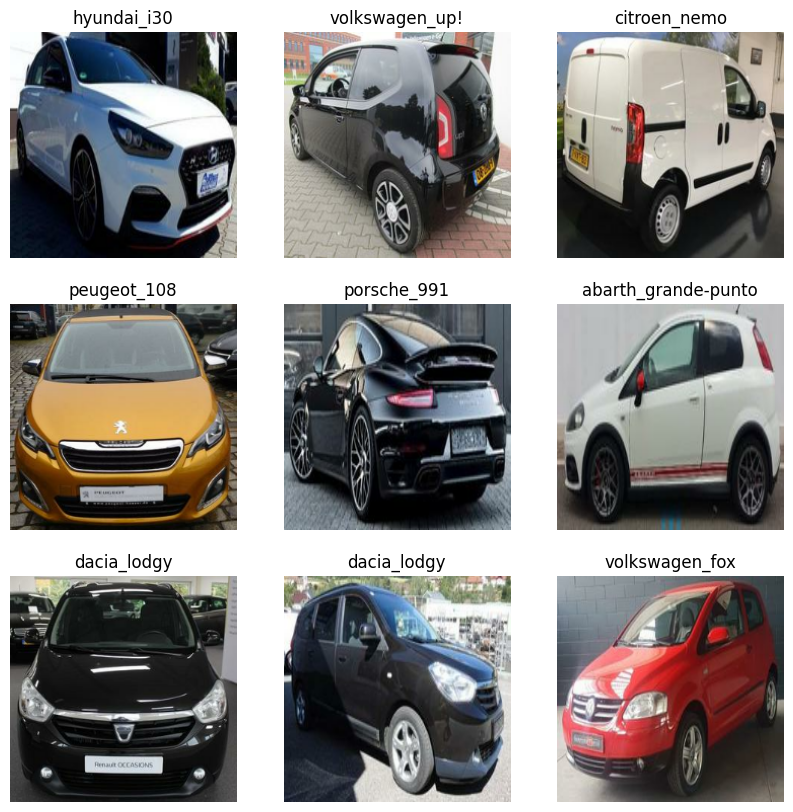

In [59]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

**Don't change anything in this cell, just make it run correctly**

In [60]:
# Configure data loader for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 3. Multi-layer Perceptron

*Now it's time to train our first Neural Network model. For simplicity, we are going to try using an MLP model.*

*A Multi-layer Perceptron (MLP) is a simple neural network consisting of multiple layers of nodes connected by weighted edges. The input and output layers have one node per feature, and one node per target class respectively, while the intermediate layers have an arbitrary number of nodes. MLPs are known to work well for simple classification tasks, but they might not be suitable for image classification, where the input data has a high dimensionality and there are correlations between adjacent pixels.*

---

Executing the following cell will create a model using the `create_mlp_model()` functions you created and then run the training pipeline for it.

Feel free to change the code below to include any other optimization algorithm or change the default optimizer parameters like the `learning rate`.

It's also a good idea to change and experiment with different parameters for the `fit()` function. Try with more epochs and also adding [callbacks](https://keras.io/api/callbacks/) for saving the best weights (`ModelCheckpoint`), storing training logs (`TensorBoard` or `CSVLogger`), changing learning rate during training depending on the improvements in the loss function (`ReduceLROnPlateau`), etc.

**Important note:** Don't modify the model layers in the `create_mlp_model()` with different parameters to what we asked you to do in the function or you will break the project unit tests. If you want to experiment further with other model settings, feel free to create your own model in a separate function.


In [12]:
mlp_model = models.create_mlp_model(
    input_shape=(img_height, img_width, 3), num_classes=len(class_names)
)

# Compile the model
mlp_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

mlp_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=30,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 512)               77070848  
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 25)                12825     
                                                                 
Total params: 78,133,785
Trainable params: 78,133,785
No

KeyboardInterrupt: 

At this point the model accuracy in the validation dataset should be around *0.3*.

What do you think about the relation between training accuracy and validation accuracy? Is the model overfitting or underfitting?

What changes can we apply to reach our goal of 0.8 (80%) accuracy on testing?

## 4. CNN: LeNet

*Multi-layer Perceptrons are known to work well for simple classification tasks, but they might not be suitable for image classification, where the input data has a high dimensionality and there are correlations between adjacent pixels.*

*If the previous model wasn't enough for the accuracy we aim to achieve, we can try a bigger one, a Convolutional Network! We are going to use the first develop CNN, the LeNet model.*

*LeNet is a type of Convolutional Neural Network (CNN) that was specifically designed for image classification. LeNet uses a set of convolutional layers to extract low-level features such as edges and corners, and then combines them into higher-level features through a series of pooling layers. Finally, a set of fully connected layers is used to classify the images. LeNet has shown to be very effective in image classification tasks, especially in cases where the input images are small and the features are not too complex.*

---

Executing the following cell will create a model using the `create_lenet_model()` function you created and then run the training pipeline for it.

Feel free to change the code below to include any other optimization algorithm or change the default optimizer parameters like the `learning rate`.

It's also a good idea to change and experiment with different parameters for the `fit()` function. Try with more epochs and also adding [callbacks](https://keras.io/api/callbacks/) for saving the best weights (`ModelCheckpoint`), storing training logs (`TensorBoard` or `CSVLogger`), changing learning rate during training depending on the improvements in the loss function (`ReduceLROnPlateau`), etc.

**Important note:** Don't modify the model layers in the `create_lenet_model()` with different parameters to what we asked you to do in the function or you will break the project unit tests. If you want to experiment further with other model settings, feel free to create your own model in a separate function.


In [13]:
lenet_model = models.create_lenet_model(
    input_shape=(img_height, img_width, 3), num_classes=len(class_names)
)

# Compile the model
lenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

lenet_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 average_pooling2d (AverageP  (None, 110, 110, 6)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 53, 53, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 44944)            

At this point the model accuracy in the validation dataset should be around *0.3*.

What do you think about the relation between training accuracy and validation accuracy? Is the model overfitting or underfitting?

What changes can we apply to reach our goal of 0.8 (80%) accuracy on testing?

## 5. CNN: Transfer learning from ResNet50

*Maybe the LeNet is still no the best choice for our task. Actually, most of the time, when solving image classification problems, the best results are achieved using pre-built CNN architecture pre-trained on imagenet dataset. This process is commonly known as **transfer learning** or **fine-tuning**.*

*ResNet50, is a much deeper CNN that was developed to tackle the problem of vanishing gradients in deep neural networks. ResNet50 is made up of many layers that are organized into blocks, each of which has a set of convolutional layers followed by shortcut connections that allow for the easy flow of information between layers. These shortcut connections help to prevent vanishing gradients and allow the network to learn very deep representations of the input images. This makes ResNet50 ideal for image classification tasks where the input images are complex and large.*

*Therefore, it would be better to use ResNet50 finetuning for image classification tasks, especially if the input images are complex and large, as it has been optimized for this specific task and has shown to be very effective in achieving state-of-the-art results. Additionally, using ResNet50 finetuning means that the model can take advantage of the pre-trained weights on a large dataset, which can lead to faster convergence and better performance on smaller datasets.*

---

Executing the following cell will create a model using the `create_resnet50_model()` function you created and then run the training pipeline for it.

Feel free to change the code below to include any other optimization algorithm or change the default optimizer parameters like the `learning rate`.

It's also a good idea to change and experiment with different parameters for the `fit()` function. Try with more epochs and also adding [callbacks](https://keras.io/api/callbacks/) for saving the best weights (`ModelCheckpoint`), storing training logs (`TensorBoard` or `CSVLogger`), changing learning rate during training depending on the improvements in the loss function (`ReduceLROnPlateau`), etc.

**Important note:** Don't modify the model layers in the `create_resnet50_model()` with different parameters to what we asked you to do in the function or you will break the project unit tests. If you want to experiment further with other model settings, feel free to create your own model in a separate function.


In [63]:
from keras import layers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

inputs = keras.Input(shape=(img_height, img_width, 3))

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),                           # Volteo horizontal y vertical
        layers.RandomRotation(0.5),                                             # Rotación aleatoria
        layers.RandomZoom(0.5),                                                 # Zoom aleatorio
        layers.RandomBrightness(0.1),                                           # Brillo aleatorio
        layers.RandomContrast(0.1),                                             # Contraste aleatorio
        layers.Lambda(lambda x: tf.image.random_saturation(x, 0.6, 1.4)),       # Saturación aleatoria
        layers.Lambda(lambda x: tf.image.random_hue(x, 0.2)),                   # Tono aleatorio
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),          # Traslación aleatoria
        layers.RandomCrop(height=img_height, width=img_width),                  # Recorte aleatorio
        layers.RandomHeight(factor=0.1),                                        # Altura aleatoria
        layers.RandomWidth(factor=0.1),                                         # Ancho aleatorio
        layers.GaussianNoise(0.1),                                              # Ruido gaussiano
        layers.Lambda(lambda x: tf.image.random_brightness(x, max_delta=0.1)),  # Brillo aleatorio (versión alternativa)
        layers.Lambda(lambda x: tf.image.random_flip_left_right(x)),            # Volteo aleatorio izquierdo-derecho
        layers.Lambda(lambda x: tf.image.random_flip_up_down(x))                # Volteo aleatorio arriba-abajo
    ]
)

augmented_inputs = data_augmentation(inputs)
preprocessed_inputs = keras.applications.resnet50.preprocess_input(augmented_inputs)

resnet50_model = models.create_resnet50_model(
    input_shape=preprocessed_inputs.shape[1:], 
    num_classes=len(class_names)
)

# Compile the model
resnet50_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4, beta_1=0.9, beta_2=0.999),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3, 
    min_lr=1e-6
)

early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

resnet50_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=[lr_scheduler, early_stopping]
)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_7 (Flatten)         (None, 100352)            0         
                                                                 
 dropout_7 (Dropout)         (None, 100352)            0         
                                                                 
 dense_7 (Dense)             (None, 25)                2508825   
                                                                 
Total params: 26,096,537
Trainable params: 2,508,825
Non-trainable params: 23,587,712
_________________________________________________________________
None
Epoch 1/20
30/30 [==============================] - 43s 1s/step - loss: 6.1147 - accuracy: 0.4005 - val_loss: 1.9403 - val_accuracy: 0.6699 - lr: 5.0000e-04
Epo

At this point the model accuracy in the validation dataset should be around *0.7*.

What do you think about the relation between training accuracy and validation accuracy? Is the model overfitting or underfitting?

What changes can we apply to reach our goal of 0.8 (80%) accuracy on testing?

## 6. Analyze model results

Choose your best model and report some metrics on the results you obtained.

You can plot a confussion matrix or use [Scikit-learn classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).


8/8 [==============================] - 7s 834ms/step
                              precision    recall  f1-score   support

          abarth_595-turismo       0.91      0.90      0.91        80
         abarth_grande-punto       0.86      0.77      0.81        78
                      bmw_z4       0.88      0.80      0.84        80
           citroen_c-crosser       0.78      0.90      0.84        77
                 citroen_ds4       0.94      0.75      0.83        80
                citroen_nemo       0.94      0.96      0.95        80
                 dacia_lodgy       0.95      0.90      0.92        80
                  ford_f-150       0.96      0.89      0.92        80
               hyundai_h-350       0.84      0.70      0.76        46
                 hyundai_i30       0.64      0.70      0.67        80
land-rover_range-rover-velar       0.80      0.95      0.87        43
           mercedes-benz_180       0.42      0.44      0.43        80
         mercedes-benz_a-180       0

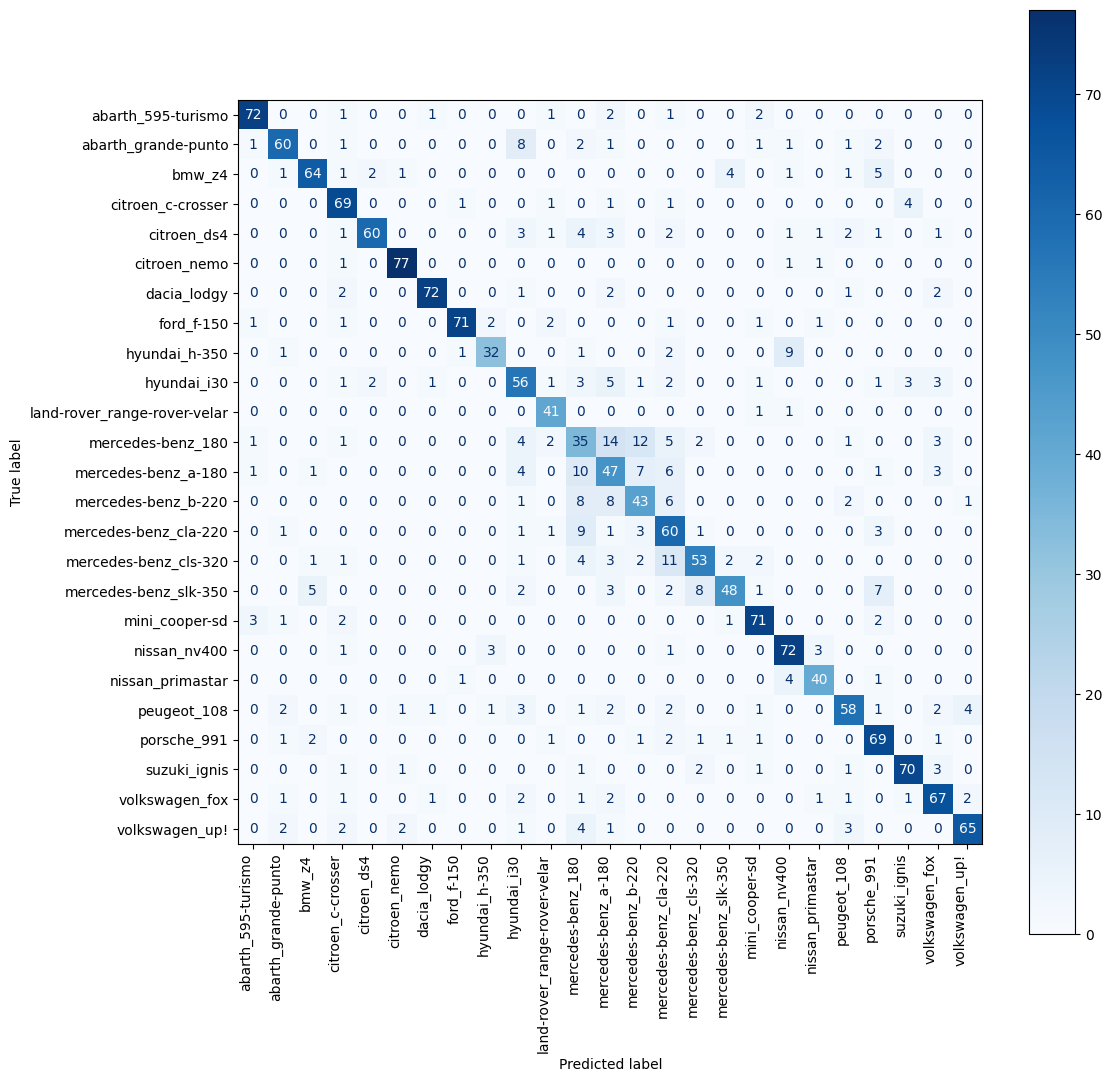

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Obtén las etiquetas verdaderas
y_true = np.concatenate([y for x, y in test_ds], axis=0)
if y_true.ndim > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

# Obtén las predicciones del modelo
y_pred = resnet50_model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Imprime el reporte de clasificación
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Calcula y visualiza la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Dibuja la matriz de confusión
fig, ax = plt.subplots(figsize=(12, 12))  # Ajusta el tamaño según sea necesario
disp.plot(cmap='Blues', ax=ax)

# Rota las etiquetas del eje x
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)

plt.show()

## 7. Optional. Make your own model

The models we've trained before are just a limited set over the universe of stuff you can use. 

You still have a lot of things to experiment with to increase accuracy, some ideas are:

1. Use any other CNN architecture you think may perform better than ResNet50.
2. Try adding data augmentation or any other regularization algorithms.
3. Train using more epochs, a different optimization algorithm, etc.
4. Check [KerasTuner](https://keras.io/api/keras_tuner/) documentation about how to efficiently test a lot of different architectures and parameters.

In [67]:
from keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Nadam
from keras.applications import ResNet50

inputs = keras.Input(shape=(img_height, img_width, 3))

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),                           # Volteo horizontal y vertical
        layers.RandomRotation(0.5),                                             # Rotación aleatoria
        layers.RandomZoom(0.5),                                                 # Zoom aleatorio
        layers.RandomBrightness(0.1),                                           # Brillo aleatorio
        layers.RandomContrast(0.1),                                             # Contraste aleatorio
        layers.Lambda(lambda x: tf.image.random_saturation(x, 0.6, 1.4)),       # Saturación aleatoria
        layers.Lambda(lambda x: tf.image.random_hue(x, 0.2)),                   # Tono aleatorio
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),          # Traslación aleatoria
        layers.RandomCrop(height=img_height, width=img_width),                  # Recorte aleatorio
        layers.RandomHeight(factor=0.1),                                        # Altura aleatoria
        layers.RandomWidth(factor=0.1),                                         # Ancho aleatorio
        layers.GaussianNoise(0.1),                                              # Ruido gaussiano
        layers.Lambda(lambda x: tf.image.random_brightness(x, max_delta=0.1)),  # Brillo aleatorio (versión alternativa)
        layers.Lambda(lambda x: tf.image.random_flip_left_right(x)),            # Volteo aleatorio izquierdo-derecho
        layers.Lambda(lambda x: tf.image.random_flip_up_down(x))                # Volteo aleatorio arriba-abajo
    ]
)

augmented_inputs = data_augmentation(inputs)
preprocessed_inputs = keras.applications.resnet50.preprocess_input(augmented_inputs)
num_classes=len(class_names)

resnet50 = ResNet50(
    input_shape=preprocessed_inputs.shape[1:], 
    weights='imagenet', 
    include_top=False,
)

for layer in resnet50.layers:
    layer.trainable = False

model = keras.Sequential()
model.add(resnet50)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation="softmax"))
print(model.summary())

# Compile the model
model.compile(
    optimizer=Nadam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=2,
    min_lr=1e-6
)

early_stopping = EarlyStopping(patience=4, restore_best_weights=True)

resnet50_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=[lr_scheduler, early_stopping]
)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_9 (Flatten)         (None, 100352)            0         
                                                                 
 dropout_9 (Dropout)         (None, 100352)            0         
                                                                 
 dense_9 (Dense)             (None, 25)                2508825   
                                                                 
Total params: 26,096,537
Trainable params: 2,508,825
Non-trainable params: 23,587,712
_________________________________________________________________
None
Epoch 1/20
30/30 [==============================] - 32s 1s/step - loss: 0.0131 - accuracy: 0.9952 - val_loss: 1.1383 - val_accuracy: 0.8048 - lr: 1.2500e-04
Epo

8/8 [==============================] - 6s 838ms/step
                              precision    recall  f1-score   support

          abarth_595-turismo       0.85      0.90      0.87        80
         abarth_grande-punto       0.95      0.73      0.83        78
                      bmw_z4       0.85      0.85      0.85        80
           citroen_c-crosser       0.85      0.87      0.86        77
                 citroen_ds4       0.83      0.84      0.83        80
                citroen_nemo       0.93      0.97      0.95        80
                 dacia_lodgy       0.95      0.96      0.96        80
                  ford_f-150       0.95      0.90      0.92        80
               hyundai_h-350       0.80      0.80      0.80        46
                 hyundai_i30       0.67      0.72      0.70        80
land-rover_range-rover-velar       0.89      0.91      0.90        43
           mercedes-benz_180       0.49      0.46      0.47        80
         mercedes-benz_a-180       0

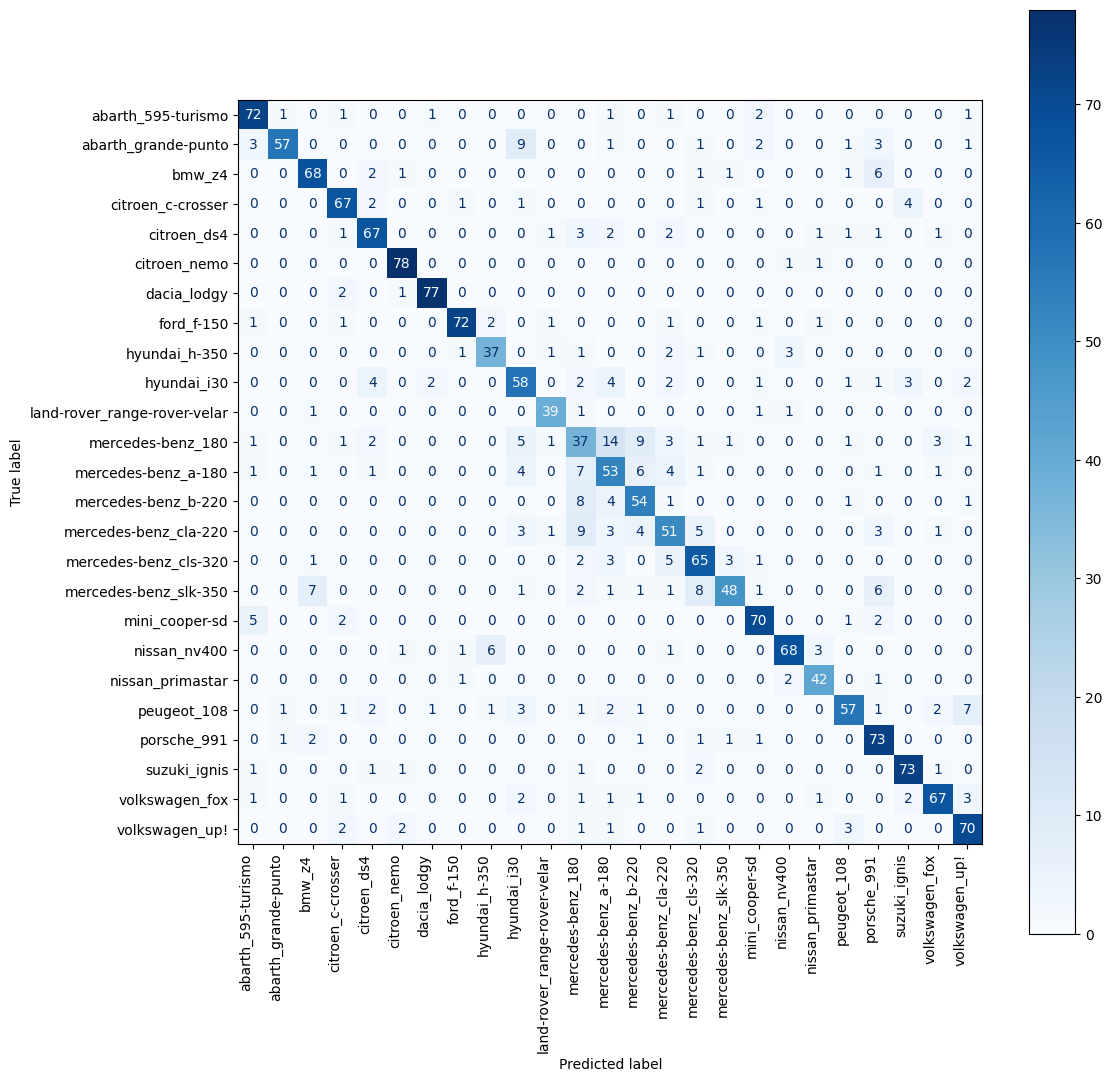

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Obtén las etiquetas verdaderas
y_true = np.concatenate([y for x, y in test_ds], axis=0)
if y_true.ndim > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

# Obtén las predicciones del modelo
y_pred = resnet50_model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Imprime el reporte de clasificación
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Calcula y visualiza la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Dibuja la matriz de confusión
fig, ax = plt.subplots(figsize=(12, 12))  # Ajusta el tamaño según sea necesario
disp.plot(cmap='Blues', ax=ax)

# Rota las etiquetas del eje x
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)

plt.show()